In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import svm
# from sklearn.linear_model import LogisticRegression
# from sklearn.pipeline import make_pipeline

# from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
# from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.decomposition import PCA

In [2]:
import warnings
warnings.filterwarnings('ignore')

# 1. Importing Data

In [3]:
import urllib
dls = "https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE124548&format=file&file=GSE124548%5FAllData%5F170308%5FRNAseq%5FKopp%5FResults%2Exlsx"
urllib.request.urlretrieve(dls, "RNASeqData.xlsx")

('RNASeqData.xlsx', <http.client.HTTPMessage at 0x17a49e5fe20>)

a. Load the file 'RNASeqData.xlsx' and save it as a pandas dataframe called data_df

In [29]:
data_df = pd.read_excel(r'I:\My Drive\5. MachineLearning&dataSci\Assignment\wk4\RNAseqData_CF40.xlsx', index_col=0)
data_df.shape

(15570, 139)

In [5]:
data_df.iloc[:,:7].head()

,ID,Description,EntrezID,Class,pre_drug.vs.control_ShrunkenLog2FC,pre_drug.vs.control_MLELog2FC,pre_drug.vs.control_pVal
RowID,,,,,,,
1,A1BG,alpha-1-B glycoprotein,1,protein_coding,-0.050497,-0.066327,0.691693
2,A1BG-AS1,A1BG antisense RNA 1,503538,lncRNA,0.004178,0.032895,0.971929
3,A2M-AS1,A2M antisense RNA 1 (head to head),144571,lncRNA,0.356337,0.932311,0.050847
4,AAAS,aladin WD repeat nucleoporin,8086,protein_coding,-0.139005,-0.152091,0.285215
5,AACS,acetoacetyl-CoA synthetase,65985,protein_coding,0.138032,0.143003,0.088856


b. Filter the dataframe to only contain the 60 columns. Call it raw_data.
Save the "ID" as gene_ids

In [6]:
raw_data = data_df.iloc[:,79:]
raw_data.shape

(15570, 60)

In [7]:
raw_data.iloc[:,:5].head()

,Raw_10_HC_Auto_066_237,Raw_11_Orkambi_006_Base,Raw_12_Orkambi_007_V2,Raw_13_HC_Auto_068_239,Raw_14_Orkambi_007_Base
RowID,,,,,
1,81,38,112,46,64
2,49,31,84,26,38
3,74,108,62,47,41
4,161,86,197,92,116
5,199,128,198,117,162


In [8]:
gene_ids = data_df['ID']
len(gene_ids)

15570

In [9]:
gene_ids.head()

RowID
1        A1BG
2    A1BG-AS1
3     A2M-AS1
4        AAAS
5        AACS
Name: ID, dtype: object

# 2. Normalization

a. Calculate the sum of each columns and call this list raw_cols_sums

In [10]:
raw_cols_sums = raw_data.sum()
raw_cols_sums.head()

Raw_10_HC_Auto_066_237     22669490
Raw_11_Orkambi_006_Base    18227720
Raw_12_Orkambi_007_V2      27910590
Raw_13_HC_Auto_068_239     19121269
Raw_14_Orkambi_007_Base    25054999
dtype: int64

b. For each gene, divide it by its corresponding raw_cols_sum, multiply it by 1,000,000

In [11]:
norm_cpm_df = pd.DataFrame([raw_data.iloc[:,i]/raw_cols_sums[i]*1000000 for i in range(60)]).transpose()
norm_cpm_df.shape

(15570, 60)

In [12]:
norm_cpm_df.iloc[:,:5].head()

,Raw_10_HC_Auto_066_237,Raw_11_Orkambi_006_Base,Raw_12_Orkambi_007_V2,Raw_13_HC_Auto_068_239,Raw_14_Orkambi_007_Base
RowID,,,,,
1,3.573084,2.084737,4.012814,2.405698,2.554380
2,2.161495,1.700706,3.009610,1.359742,1.516663
3,3.264299,5.925042,2.221379,2.457996,1.636400
4,7.102057,4.718089,7.058253,4.811396,4.629815
5,8.778318,7.022272,7.094081,6.118841,6.465776


In [13]:
norm_cpm_df.sum().head()

Raw_10_HC_Auto_066_237     1000000.0
Raw_11_Orkambi_006_Base    1000000.0
Raw_12_Orkambi_007_V2      1000000.0
Raw_13_HC_Auto_068_239     1000000.0
Raw_14_Orkambi_007_Base    1000000.0
dtype: float64

# 3. Top 10 genes

In [14]:
top10_ci_genes = ['LOC105372578',
                'MCEMP1',
                'MMP9',
                'SOCS3',
                'ANXA3',
                'G0S2',
                'IL1R2',
                'PFKFB3',
                'OSM',
                'SEMA6B']

a. Filter norm_cpm_df to contain only genes listed above. Call this norm_cpm_df_top10.

In [15]:
norm_cpm_df.set_index(gene_ids, inplace=True)
norm_cpm_df.iloc[:5,:5]

,Raw_10_HC_Auto_066_237,Raw_11_Orkambi_006_Base,Raw_12_Orkambi_007_V2,Raw_13_HC_Auto_068_239,Raw_14_Orkambi_007_Base
ID,,,,,
A1BG,3.573084,2.084737,4.012814,2.405698,2.554380
A1BG-AS1,2.161495,1.700706,3.009610,1.359742,1.516663
A2M-AS1,3.264299,5.925042,2.221379,2.457996,1.636400
AAAS,7.102057,4.718089,7.058253,4.811396,4.629815
AACS,8.778318,7.022272,7.094081,6.118841,6.465776


In [16]:
norm_cpm_df_top10sub = norm_cpm_df.loc[top10_ci_genes,:]
norm_cpm_df_top10sub.shape

(10, 60)

In [17]:
norm_cpm_df_top10sub.iloc[:,:5]

,Raw_10_HC_Auto_066_237,Raw_11_Orkambi_006_Base,Raw_12_Orkambi_007_V2,Raw_13_HC_Auto_068_239,Raw_14_Orkambi_007_Base
ID,,,,,
LOC105372578,3.484860,7.570887,2.508009,4.759098,29.854322
MCEMP1,5.866916,4.882673,2.758809,4.759098,30.053883
MMP9,48.214583,68.906040,83.480858,59.044198,380.004006
SOCS3,66.829911,131.941899,42.313688,83.362668,352.584329
ANXA3,55.272527,71.045638,20.995615,83.205775,307.603285
G0S2,1.235140,5.431288,2.113893,1.464338,7.224107
IL1R2,55.228415,93.483990,49.515256,83.414966,154.100984
PFKFB3,39.656825,59.963616,27.516437,62.652745,249.411305
OSM,6.881496,14.702881,5.338475,8.263050,40.830175


The columns of the dataframe are labeled as such:
-	any column name that has the term HC is a Health Control
-	any column with Base is a patient with CF but no Treatment
-	any column with V2 is a CF patient with treatment

b. Split norm_cpm_df_top10 into 2 different dataframes
-	one with just healthy values, call it hc_top10
-	one with just CF (Base) values , call it cf_top10

In [18]:
import re
hc_cnames = ['HC'in c_name for c_name in list(norm_cpm_df_top10sub)]
hc_top10 = norm_cpm_df_top10sub.loc[: , hc_cnames]
hc_top10.shape

(10, 20)

In [19]:
cf_cnames = ['Base' in c_name for c_name in list(norm_cpm_df_top10sub)]
cf_top10 = norm_cpm_df_top10sub.loc[: , cf_cnames]
cf_top10.shape

(10, 20)

In [20]:
tr_cnames = ['V2' in c_name for c_name in list(norm_cpm_df_top10sub)]
tr_top10 = norm_cpm_df_top10sub.loc[: , tr_cnames]
tr_top10.shape

(10, 20)

c. Transpose both dataframes so that the gene ids will now be columns. Call it hc_top10_t and cf_top10_t

In [21]:
hc_top10_t = hc_top10.transpose()
cf_top10_t = cf_top10.transpose()

- Add a new column filled with 0 to hc_top_t call it Y
- Add a new column filled with 1 to cf_top_t call it Y
Y is going to be our label

d. Merge hc_top10_t and cf_top10_t. You should now have 40 rows and 11 columns.
Call this hc_cf_top10

In [22]:
hc_top10_t['Y'] = 0
cf_top10_t['Y'] = 1
hc_cf_top10 = pd.concat([hc_top10_t, cf_top10_t])
hc_cf_top10.shape

(40, 11)

In [23]:
hc_cf_top10.head()

ID,LOC105372578,MCEMP1,MMP9,SOCS3,ANXA3,G0S2,IL1R2,PFKFB3,OSM,SEMA6B,Y
Raw_10_HC_Auto_066_237,3.484860,5.866916,48.214583,66.829911,55.272527,1.235140,55.228415,39.656825,6.881496,1.235140,0
Raw_13_HC_Auto_068_239,4.759098,4.759098,59.044198,83.362668,83.205775,1.464338,83.414966,62.652745,8.263050,0.993658,0
Raw_16_HC_Auto_072_243,3.430145,4.668809,53.643662,91.121177,81.402431,2.032679,83.847998,63.616492,8.988251,1.016339,0
Raw_19_HC_Auto_074_245,2.832716,3.142544,22.971555,42.490738,35.630254,1.991753,61.921398,41.516992,5.045775,1.018007,0
Raw_21_HC_Immune_004,6.348553,5.668351,49.946267,99.503848,88.458661,1.749091,88.264318,50.496907,9.911516,1.068889,0


## cross validation use 5X cross validation on the entire dataset & random_state = 1 

a. Split hc_cf_top10 into X and Y. 

In [24]:
X,y = hc_cf_top10.iloc[:, :10], hc_cf_top10.iloc[:, -1]
(X.shape, y.shape)

((40, 10), (40,))

In [25]:
X.head()

ID,LOC105372578,MCEMP1,MMP9,SOCS3,ANXA3,G0S2,IL1R2,PFKFB3,OSM,SEMA6B
Raw_10_HC_Auto_066_237,3.484860,5.866916,48.214583,66.829911,55.272527,1.235140,55.228415,39.656825,6.881496,1.235140
Raw_13_HC_Auto_068_239,4.759098,4.759098,59.044198,83.362668,83.205775,1.464338,83.414966,62.652745,8.263050,0.993658
Raw_16_HC_Auto_072_243,3.430145,4.668809,53.643662,91.121177,81.402431,2.032679,83.847998,63.616492,8.988251,1.016339
Raw_19_HC_Auto_074_245,2.832716,3.142544,22.971555,42.490738,35.630254,1.991753,61.921398,41.516992,5.045775,1.018007
Raw_21_HC_Immune_004,6.348553,5.668351,49.946267,99.503848,88.458661,1.749091,88.264318,50.496907,9.911516,1.068889


In [26]:
y.head()

Raw_10_HC_Auto_066_237    0
Raw_13_HC_Auto_068_239    0
Raw_16_HC_Auto_072_243    0
Raw_19_HC_Auto_074_245    0
Raw_21_HC_Immune_004      0
Name: Y, dtype: int64

a. Perform SVM using the cross validation function.
Perform 5x cross validation Try:
- different values for C ( less than 1, 1, and greater than 1)
- different kernels (linear and radial)

In [27]:
kn = ['rbf', 'linear', 'poly', 'sigmoid']
c_val = [-0.5, 1, 5, 10, 100]

for k in kn:
    for c_v in c_val:
        clf = svm.SVC(kernel=k, random_state=1,C=c_v)
        scores = cross_val_score(clf, X, y, cv=5)
        print(f'with kernal={k}, C={c_v}: accuracy={scores.mean()}, std={round(scores.std(),2)}\n ')
    print('======')

with kernal=rbf, C=-0.5: accuracy=nan, std=nan
 
with kernal=rbf, C=1: accuracy=0.85, std=0.09
 
with kernal=rbf, C=5: accuracy=0.85, std=0.09
 
with kernal=rbf, C=10: accuracy=0.85, std=0.09
 
with kernal=rbf, C=100: accuracy=0.85, std=0.05
 
with kernal=linear, C=-0.5: accuracy=nan, std=nan
 
with kernal=linear, C=1: accuracy=0.8, std=0.06
 
with kernal=linear, C=5: accuracy=0.8, std=0.06
 
with kernal=linear, C=10: accuracy=0.775, std=0.05
 
with kernal=linear, C=100: accuracy=0.775, std=0.05
 
with kernal=poly, C=-0.5: accuracy=nan, std=nan
 
with kernal=poly, C=1: accuracy=0.8, std=0.1
 
with kernal=poly, C=5: accuracy=0.85, std=0.09
 
with kernal=poly, C=10: accuracy=0.825, std=0.13
 
with kernal=poly, C=100: accuracy=0.825, std=0.06
 
with kernal=sigmoid, C=-0.5: accuracy=nan, std=nan
 
with kernal=sigmoid, C=1: accuracy=0.625, std=0.08
 
with kernal=sigmoid, C=5: accuracy=0.525, std=0.12
 
with kernal=sigmoid, C=10: accuracy=0.5, std=0.14
 
with kernal=sigmoid, C=100: accuracy=

b. Best combination in my calculation is RBF when C = 100: 
- the accuracy=0.85, std=0.05

c. explain the score is reported.

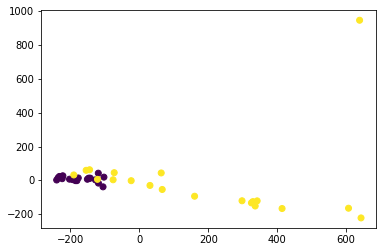

In [28]:
# plotting to review the data
# reduce dimension
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)

plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y)
plt.show()

The score was calculated by splitting the data, fitting a model and computing the score 5 consecutive times. the corresponding mean & standard deviation of the 5 scores were reported for each model. 
Based on research that has been done, it is obtained that the accuracy values generated by SVM with RBF kernel functions is higher than the other kernel functions. RBF uses normal curves around the data points, and sums these so that the decision boundary can be defined by a type of topology condition. Higher C value means less regulation and thus the dicision boundary become more bump and coarse. 